#### Chapter 8: Attention and the Transformer
*RNN is losing its luster with researchers.*

RNNs can be a pain: parallelization can be tricky and they can be difficult to debug. Attention have achieving state of the art results on NLP. Convolutions may beat attention on some tasks, including English to German translation. Perhaps various strengths of RNNs, CNNs, and transformers/attention combine the best of each. 

## NOTE: 
This notebook easily gets out of memory error. In order to run without restarting jupyter notebook, choose one of the following: 
- Decreasing batch size until you can run both without CUDA OOM. 
- Deleting unneeded `learn`, etc. This is already done in this notebook (hopefully) to reduce memory wastage. However, this is not certain. Sometimes it takes time before python's internal program clear its cache, especially for GPU. Even `torch.cuda.empty_cache()` is not certain. It is unsure whether proper delete will make it certain. 
- Use a GPU with large Memory. Ideally, you need 18GB (predicted) to run properly. Better, get a GPU instance with 40GB or more, just to make sure it runs without human intervention. (You could rent one of the A6000 instances on [Datacrunch.io](https://datacrunch.io/) for $1.10 per hour, and you can use jupyter notebook with fastai image already provided by DataCrunch, or [follow this guide to set it up yourself](https://wabinab.github.io/2021/06/30/Setting-up-Datacrunch.io-from-scratch.html) ).

The Kaggle notebook is [here](https://www.kaggle.com/wabinab/fastai-nlp-chapter-8)

In [1]:
from fastai.text.all import *
# from utils import *
from nlp_utils import *  # different name used in Kaggle platform
from IPython.display import clear_output

path = Path("../input/nlp-fastai-dataset-chapter-8")
path.ls()

(#1) [Path('../input/nlp-fastai-dataset-chapter-8/questions_easy.csv')]

It seems like too short a sequence length doesn't give good values here? (unsure) So we use the default sequence length. 

In [2]:
df = pd.read_csv(path/"questions_easy.csv")
df["en"] = df["en"].apply(lambda x: x.lower())
df["fr"] = df["fr"].apply(lambda x: x.lower())

sl = 72

dls = DataBlock(
    blocks=(TextBlock.from_df("fr", seq_len=sl, tok=SpacyTokenizer("fr")), 
            TextBlock.from_df("en", seq_len=sl, tok=SpacyTokenizer("en"))),
    get_x=ColReader("text"), get_y=ColReader("text"),
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=64, num_workers=os.cpu_count(), seq_len=sl)
dls.show_batch(max_n=2)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos dans un tel cas , où il s’ agit d ’ apprécier si un nom commercial a un fondement juridique antérieur à celui d ’ une marque aux fins de l’ article 16 , paragraphe 1 , troisième phrase , de l’ accord adpic , peut -on considérer comme décisif : i ) le fait que , dans l’ état où la marque est enregistrée et sa protection réclamée , le nom commercial ait été , du moins dans une certaine mesure , connu dans les milieux professionnels xxunk xxunk de l’ état concerné avant la date à laquelle l’ enregistrement de la marque y a été demandé ; ou que , dans les relations commerciales intéressant l’ état où la marque est xxunk ée et sa protection réclamée , le nom commercial ait été utilisé avant la date à laquelle l’ enregistrement de la marque a été demandé","xxbos when assessing , in such a case , whether a trade name has a legal basis prior to a trade mark for the purposes of the third sentence of article 16(1 ) of the trips agreement , may it thus be considered as decisive : ( i ) whether the trade name was well known at least to some extent among the relevant trade circles in the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or whether the trade name was used in commerce directed to the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or what other factor may decide whether the trade name is to be regarded as an existing prior right within the meaning of the third sentence of article 16(1 ) of the trips agreement ?"
1,"xxbos que nous disent les médias au sujet de ses antécédents , de son patrimoine et de sa culture , des conditions dans lesquelles elle a grandi et a vécu ses années d’ adolescence ( lorsqu’ elle a commencé à xxunk des xxunk de solvants ) , des facteurs qui ont déclenché sa toxicomanie , de sa vie familiale , de l’ appui de son réseau de soutien social , de ses tentatives de traitement , de rétablissement et de guérison , de ses sentiments face à la maternité , de sa lutte contre la pauvreté , de son opinion quant au traitement approprié et utile , de ses aspirations ?","xxbos what does the media tell us about her background , her heritage and culture , the conditions in which she grew up and lived as an adolescent ( when her solvent addiction began ) , the precipitating factors leading to her solvent use , her family life , her social support network , her attempts at treatment , recovery and healing , her feelings about motherhood , her struggles living in poverty , her views on what appropriate and useful treatment would be , and her aspirations ?"


## Transformer Model
### Shifting
We add transform to dataloader that shifts the targets right and adds a padding at the beginning. 

In [3]:
v = dls.vocab[0]
stoi(v, "xxpad")

1

Due to how fastai v2 works differently, although we can modify the dls, however it doesn't give the expected output. In fact, `after_batch` in `Transform` only returns either `x` or `y` rather than a tuple of `(x, y)`, resulting in error. Therefore, what we could do is to instead do the transformations during Callback. 

In [4]:
def shift_tfm(b):
    x, y = b
    y = F.pad(y, (1, 0), value=1)
    return [x, y[:, :-1]], y[:, 1:]

# class ShiftTfm(Transform):
#     def encodes(self, b): return shift_tfm(b)
#     def decodes(self, b): return b

class ShiftTfm(Callback):
    def before_batch(self): 
        self.learn.xb, _ = shift_tfm((self.x, self.y))


# dls.add_tfms([ShiftTfm()], "after_batch")

It seems that we are unsure where does the **original** of the second value of `shift_tfm` should be assigned to. One doesn't know. However, if we check, then we know that `y[:, 1:]` is actually the original target. Hence, the target we did not modify, we just modify `self.learn.xb` so we can leave it without assigning it to anything. 

### Embeddings
The input and output embeddings are traditional PyTorch embeddings (or pretrained vectors). Transformer model isn't recurrent, so it has no idea of relative positions of words. TO help with that, input embeddings a positional encoding used which is cosine of certain frequency. 

In [5]:
d = 30
torch.arange(0., d, 2.) / d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

In [6]:
class PositionalEncoding(Module):
    """
    Encode the position with a sinusoid. 
    """
    def __init__(self, d): 
        self.register_buffer("freq", 1 / (1e4 ** (torch.arange(0., d, 2.) / d)))

    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

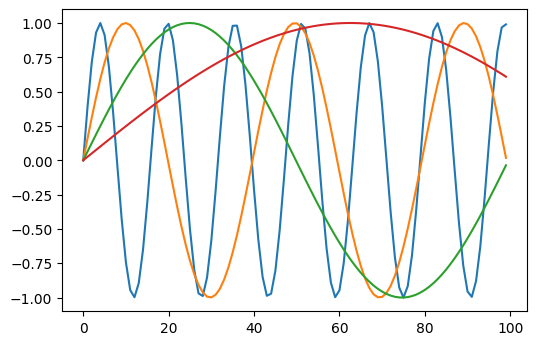

In [7]:
tst_enc = PositionalEncoding(20)
res = tst_enc(torch.arange(0, 100).float())
plt.figure(dpi=100)
for i in range(1, 5): plt.plot(res[:, i])

In [8]:
res[:6, :6]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500]])

In [9]:
class TransformerEmbedding(Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super(TransformerEmbedding, self).__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
        self._msq_emb_sz = math.sqrt(self.emb_sz)

    def forward(self, inp):
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * self._msq_emb_sz + self.pos_enc(pos))

### Feed Forward
Two linear layers with skip connection and LayerNorm. 

In [10]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p),
                MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

In [11]:
class MultiHeadAttention(Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super(MultiHeadAttention, self).__init__()
        d_head = ifnone(d_head, d_model // n_heads)
        self.n_heads, self.d_head, self.scale = n_heads, d_head, scale
        self.q_wgt, self.k_wgt, self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias
        ) for o in range(3)]

        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att, self.drop_res = nn.Dropout(p), nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(
            self._apply_attention(q, kv, mask=mask))))
        
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                        ).permute(0, 2, 1, 3)

    def _apply_attention(self, q, kv, mask=None):
        bs, seq_len = q.size(0), q.size(1)
        wq, wk, wv = map(lambda o: self.create_attn_mat(*o, bs),
                        zip( (q, kv, kv), (self.q_wgt, self.k_wgt, self.v_wgt) ))
        
        attn_score = wq @ wk.transpose(2, 3)
        if self.scale: attn_score /= math.sqrt(self.d_head)

        if mask is not None:
            attn_score = attn_score.float().masked_fill(mask, -float("inf")) \
                                    .type_as(attn_score)

        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv

        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

## Masking
The attention layer uses a mask to avoid paying attention to certain timesteps. First thing is we don't really want network to pay attention to padding, so we're going to mask it. Second is model isn't recurrent, we need to mask (in output) all tokens we're not supposed to see yet (otherwise cheating). 

In [12]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones((inp.size(1), inp.size(1))),
    diagonal=1)[None, None].bool()


torch.triu(torch.ones(10, 10), diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

### Encoder and Decoder Block
Regroup layers in blocks. 

In [13]:
class EncoderBlock(Module):
    """Encoder block of Transformer Model."""
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True,
                scale=True, double_drop=True):
        super(EncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias,
                    scale=scale)
        self.ff = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [14]:
class DecoderBlock(Module):
    """Decoder Block of a Transformer"""
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True,
                scale=True, double_drop=True):
        super(DecoderBlock, self).__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)

    def forward(self, x, enc, mask_out=None): 
        return self.ff(self.mha2(
            self.mha1(x, x, mask_out), enc
        ))

### The Whole Model

In [15]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256,
                d_head=32, d_inner=1024, p=0.1, bias=True, scale=True, 
                double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        self.n_layers = n_layers

        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)

        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx

    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc, out = self.enc_emb(inp), self.dec_emb(out)
        for encd in self.encoder: enc = encd(enc)
        for k, decd in enumerate(self.decoder): out = decd(out, enc, mask_out)
            
        ### The below code now raises NotImplementedError without any explanation.
        ### One could only infer how to implement the code below. 
        ### However, the best would just be to use PyTorch's 
        ### nn.Transformer module instead of manual implementation nowadays. 

        # enc = compose(self.encoder)(enc)
        # out = compose(self.decoder)(out, enc, mask_out)

        return self.out(out)

### Training
Due to the change of `compose` function, and change in PyTorch's `nn.ModuleList` function, the code above no longer works. We shall abandon here and see whom could solve this issue. As mentioned, new PyTorch's `nn.Transformer` does everything in one line of code, so in practice you don't need to write anything above anymore and just do that single line of code. 

One tries with `nn.Transformer` and encounters 2 problems: 
- Unlike fastai, it doesn't allow you to use varying `seq_len`. Hence, it must pass the test `assert seq_len == d_model`. This isn't true in fastai dataloaders. 
- Our input is of type `torch.Long` (expected because it is the Numericalized text, which are all integers). However, `nn.Transformer` can only take in floats, and will raise "adam backward not supported for `torch.Long`" instead. 

So, one doesn't know how to fix this. 

In [16]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

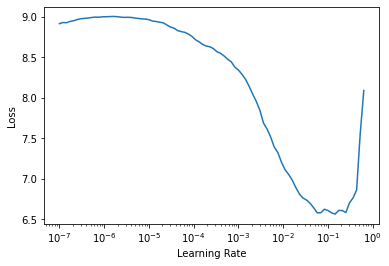

In [17]:
n_x_vocab, n_y_vocab = [len(a) for a in dls.vocab]

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(dls, model, metrics=[accuracy, CorpusBLEUMetric(n_y_vocab)],
                loss_func=CrossEntropyLossFlat(), cbs=ShiftTfm()).to_fp16()
learn.lr_find()

`div_factor` is now renamed as `div`. 

In [18]:
learn.fit_one_cycle(8, 5e-4, div=5)

epoch,train_loss,valid_loss,accuracy,corpus_bleu,time
0,2.612405,2.551680,0.613113,0.506034,02:47
1,2.394847,2.276959,0.640047,0.520348,02:47
2,2.076768,1.978643,0.682057,0.545243,02:46
3,1.746329,1.633782,0.730228,0.580947,02:47
4,1.427112,1.458523,0.751800,0.601048,02:46
5,1.244635,1.375440,0.765143,0.616254,02:47
6,1.095367,1.342858,0.771417,0.623865,02:46
7,1.041345,1.343557,0.772104,0.624996,02:46


Due to the prediction requires callback as well, we can't just use `learn.get_preds`. Instead, we have to write our own `get_predictions` now. 

In [19]:
def get_preds(learn):
    learn.model.eval()
    inputs, targets, outputs = [], [], []

    with torch.no_grad():
        for xb, yb in progress_bar(learn.dls.valid):
            xb, yb = shift_tfm((xb, yb))
            out = learn.model(*xb)

            for x, y, z in zip(xb[0], xb[1], out):
                inputs.append(x.cpu())
                targets.append(y.cpu())
                outputs.append(z.argmax(1).cpu())

    clear_output()
    
    return inputs, targets, outputs

In [20]:
class GetPreds:
    def __init__(self, inputs, preds, targs):
        self.inputs, self.preds, self.targs = inputs, preds, targs

    def get_predictions(self, num, ignore_pad=False): 
        """:ignore_pad: Whether to ignore pad for predictions. Default: False"""
        return (
            itos(dls.vocab[0], self.inputs[num], join=True, ignore_pad=True),
            itos(dls.vocab[1], self.targs[num], join=True, ignore_pad=True),
            itos(dls.vocab[1], self.preds[num], join=True, ignore_pad=ignore_pad)
        )

In [21]:
# inputs, preds, targs = learn.get_preds(with_input=True)
inputs, targs, preds = get_preds(learn)
p = GetPreds(inputs, preds, targs)

In [22]:
p.get_predictions(10, ignore_pad=True)

("xxbos comment alors faut -il interpréter le cas des nez xxunk , qui , à la fin du xxunk siècle , ne se xxunk plus quand et comment ils en étaient venus à avoir des chevaux — un événement capital qu' on sait ne s' être produit qu' un siècle auparavant et qui a causé une transformation xxunk de la culture , qui de xxunk est devenue xxunk ?",
 'xxbos what then , are we to make of the xxunk xxunk who , by the late xxunk century , could no longer remember how and when they first acquired horses -- a xxunk event that is known to have occurred only a century earlier and led to a radical transformation from a xxunk to an xxunk culture ?',
 'xxbos what then is is the going be a a xxunk xxunk , xxunk who the xxunk - , , when not longer be us they do they were xxunk the a a xxunk , , was not as be a as a xxunk ? xxunk a to be xxunk a , a xxunk , be xxunk , ,')

In [23]:
p.get_predictions(700, ignore_pad=True)

('xxbos qu’ est -ce que les constatations indiquent quant à la nature réelle de la participation des jeunes à la vie politique au brésil ?',
 'xxbos what do the results suggest about the real nature of youth and political involvement in brazil ?',
 'xxbos what do the findings of about the nature nature of youth participation youth participation in brazil in')

In [24]:
p.get_predictions(701, ignore_pad=True)

('xxbos quand le plan d’ action sera -t -il formulé , et est -ce que vous pouvez nous consulter tout au long du projet ?',
 'xxbos when does the action plan get xxunk , and can you consult us throughout the process , as we would be really happy to help and be involved',
 'xxbos when the the action plan come the , and what you find it about the project ? what long find be the care ? the ? in the in')

In [25]:
p.get_predictions(2500, ignore_pad=True)

("xxbos quel est le meilleur xxunk pour le traitement d' un xxunk - réservoir ?",
 'xxbos which chemical is best for xxunk treatment ?',
 'xxbos what is is the for xxunk treatment for')

In [26]:
p.get_predictions(4002, ignore_pad=True)

('xxbos que devrais -je savoir sur le cancer du sein ?',
 'xxbos what should i know about breast cancer ?',
 'xxbos what should i know about cancer cancer ?')

### Label Smoothing
Helped getting better BLEU/accuracy, even if it made the loss worse. 

In [27]:
try: del model, learn, inputs, preds, targs
except Exception: pass
import gc
gc.collect()
torch.cuda.empty_cache()

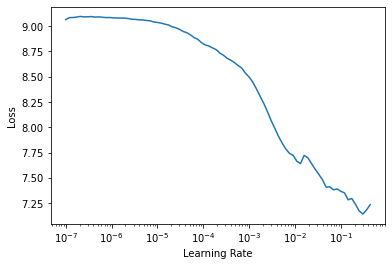

In [28]:
model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
runtimeerror = True
while runtimeerror:
    try:
        learn = Learner(dls, model, metrics=[accuracy, CorpusBLEUMetric(n_y_vocab)],
                        loss_func=LabelSmoothingCrossEntropyFlat(axis=-1),
                        cbs=ShiftTfm()).to_fp16()
        learn.lr_find()
        runtimeerror = False
    except RuntimeError:
        torch.cuda.empty_cache()
        gc.collect()

In [29]:
learn.fit_one_cycle(8, 5e-4, div=5)

epoch,train_loss,valid_loss,accuracy,corpus_bleu,time
0,3.571004,3.431255,0.618098,0.509598,02:47
1,3.133108,3.105065,0.667916,0.533687,02:47
2,2.832716,2.787843,0.716181,0.570317,02:47
3,2.610104,2.624961,0.738432,0.594186,02:49
4,2.380480,2.470355,0.762328,0.612921,02:50
5,2.226314,2.415938,0.772480,0.625386,02:49
6,2.149630,2.397299,0.777689,0.630968,02:50
7,2.112837,2.397541,0.778005,0.631917,02:50


In [30]:
gc.collect()
torch.cuda.empty_cache()

inputs, targs, preds = get_preds(learn)
p = GetPreds(inputs, preds, targs)

In [31]:
p.get_predictions(10, ignore_pad=True)

("xxbos comment alors faut -il interpréter le cas des nez xxunk , qui , à la fin du xxunk siècle , ne se xxunk plus quand et comment ils en étaient venus à avoir des chevaux — un événement capital qu' on sait ne s' être produit qu' un siècle auparavant et qui a causé une transformation xxunk de la culture , qui de xxunk est devenue xxunk ?",
 'xxbos what then , are we to make of the xxunk xxunk who , by the late xxunk century , could no longer remember how and when they first acquired horses -- a xxunk event that is known to have occurred only a century earlier and led to a radical transformation from a xxunk to an xxunk culture ?',
 'xxbos what , is is the going do a a xxunk , , has who the xxunk xxunk , , when not longer be the was xxunk they were nations the from a product , was was not to be been in a xxunk , xxunk how to the xxunk ? ? the xxunk , be xxunk , ?')

In [32]:
p.get_predictions(700, ignore_pad=True)

('xxbos qu’ est -ce que les constatations indiquent quant à la nature réelle de la participation des jeunes à la vie politique au brésil ?',
 'xxbos what do the results suggest about the real nature of youth and political involvement in brazil ?',
 'xxbos what do the findings tell about the nature nature of youth participation the participation in brazil ?')

In [33]:
p.get_predictions(701, ignore_pad=True)

('xxbos quand le plan d’ action sera -t -il formulé , et est -ce que vous pouvez nous consulter tout au long du projet ?',
 'xxbos when does the action plan get xxunk , and can you consult us throughout the process , as we would be really happy to help and be involved',
 'xxbos when will the action plan to xxunk , and what you find with to the long ? be a know be able consulted ? the ? the the in')

In [34]:
# This looks problematic with input as English instead of French... 
p.get_predictions(4001, ignore_pad=True)

('xxbos pour quelle maladie ou xxunk la guérison est-elle nécessaire ?',
 'xxbos what is the disease or xxunk for which healing is needed ?',
 'xxbos what is the xxunk or xxunk that the it is necessary ?')

Perhaps there are some problems with the data itself. 

## Test Leakage
If we change a token in targets at position n, it shouldn't impact the preds before that. 

In [35]:
learn.model.eval()

xb, yb = dls.one_batch()
xb, yb = shift_tfm((xb, yb))  # as usual, we need this since its now in callback.

# We make some changes as our batch shape isn't the same as the original code. 
inp1, out1 = xb[0], xb[1]
inp2, out2 = inp1.clone(), out1.clone()
out2[15] = 10

In [36]:
y1 = learn.model(inp1, out1)
y2 = learn.model(inp2, out2)

In [37]:
(y1[0, :15] - y2[0, :15]).abs().mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)